In [63]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader,TensorDataset
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.datasets import make_blobs
import matplotlib.pyplot as plt

In [64]:
device=torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

# Dataset

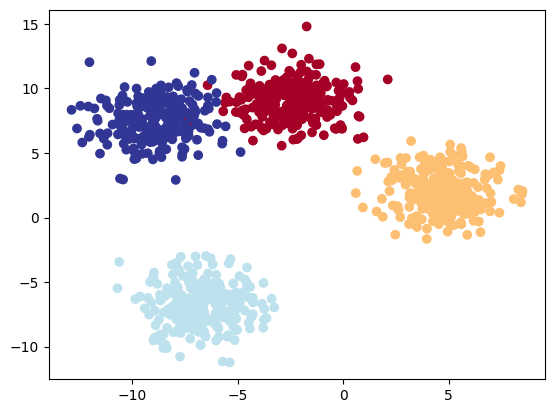

In [65]:
X,y= make_blobs(n_samples=1000,n_features=2,centers=4,shuffle=True,random_state=42,cluster_std=1.5)
plt.scatter(X[:,0],X[:,1],c=y,cmap='RdYlBu')

In [66]:
print(X.dtype), print(y.dtype)

float64
int64


(None, None)

In [67]:
X_tensor=torch.tensor(X,dtype=torch.float32)
y_tensor=torch.tensor(y,dtype=torch.long)  # nn.CrossEntropyLoss requires class indices, not one-hot or float.
X_train,X_test,y_train,y_test=train_test_split(X_tensor,y_tensor,test_size=0.2,random_state=42)

X_train=X_train.to(device)
X_test=X_test.to(device)
y_train=y_train.to(device)
y_test=y_test.to(device)

# Bundles your features (X) and labels (y) together into a single dataset object.
# Allows each sample to be accessed as a (data, label) pair.

train_ds =  TensorDataset(X_train, y_train)
test_ds = TensorDataset(X_test, y_test)

train_loader = DataLoader(train_ds, batch_size=32, shuffle=True)     # Breaks it into mini-batches (e.g., 32 samples at a time).
test_loader=DataLoader(test_ds,batch_size=32, shuffle=True)

# Model

In [68]:
class BlobClassifier(nn.Module):
    def __init__(self):
       super().__init__()
       self.fc=nn.Sequential(
           nn.Linear(in_features=2,out_features=16),
           nn.ReLU(),
           nn.Linear(in_features=16,out_features=16),
           nn.ReLU(),
           nn.Linear(in_features=16,out_features=4),
         #  nn.Softmax(dim=1)  -> CrossEntropyLoss expects raw logits.
       )
    def forward(self,x):
      return self.fc(x)

model=BlobClassifier().to(device)
criterion=nn.CrossEntropyLoss()
optimizer=optim.Adam(model.parameters(),lr=0.01)
model

BlobClassifier(
  (fc): Sequential(
    (0): Linear(in_features=2, out_features=16, bias=True)
    (1): ReLU()
    (2): Linear(in_features=16, out_features=16, bias=True)
    (3): ReLU()
    (4): Linear(in_features=16, out_features=4, bias=True)
  )
)

# Before Training

In [69]:
model.eval()
with torch.inference_mode():
  y_logits=model(X_test)
  y_pred=torch.argmax(y_logits,dim=1)
y_pred

tensor([2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
        2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
        2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 2, 2, 2, 2, 2,
        2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
        2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
        2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
        2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
        2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
        2, 2, 2, 2, 2, 2, 2, 2], device='cuda:0')

# Training

In [70]:
epochs=1000
for epoch in range(epochs):
  model.train()
  tot_loss=0
  for data,label in train_loader:
    output= model(data)
    loss=criterion(output,label)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    tot_loss+=loss.item()

  if epoch % 100 == 0:
      print(f'Epoch: {epoch} | Loss: {tot_loss:.4f}')

Epoch: 0 | Loss: 13.0137
Epoch: 100 | Loss: 0.5486
Epoch: 200 | Loss: 0.4400
Epoch: 300 | Loss: 0.3603
Epoch: 400 | Loss: 0.3467
Epoch: 500 | Loss: 0.3782
Epoch: 600 | Loss: 0.3509
Epoch: 700 | Loss: 0.3975
Epoch: 800 | Loss: 0.5195
Epoch: 900 | Loss: 0.4776


# Training

In [71]:
model.eval()
with torch.inference_mode():
  y_logits=model(X_test)
  y_pred=torch.argmax(y_logits,dim=1)
accuracy=sum(y_pred==y_test)
accuracy=accuracy/len(y_test)
print(f'Accuracy: {accuracy*100:.2f}%')

Accuracy: 100.00%


In [72]:
next(model.parameters())

Parameter containing:
tensor([[ 0.4268,  0.2358],
        [-0.5764, -1.4862],
        [-0.6613, -1.2697],
        [-0.4848, -1.7326],
        [ 1.7555, -0.5213],
        [ 0.0812, -0.1320],
        [-0.9899, -0.4418],
        [ 1.7807,  0.7911],
        [ 2.1460, -0.4644],
        [ 0.5909, -0.0413],
        [-1.2777,  0.0818],
        [-0.0759, -0.0663],
        [-1.4997, -1.8813],
        [ 0.3665,  0.3465],
        [ 0.7521, -0.2217],
        [-0.3664, -0.8491]], device='cuda:0', requires_grad=True)

In [74]:
torch.save(model.state_dict(), 'blob_classifier.pth')

In [76]:
saved_model = BlobClassifier().to(device)  # Recreate the same model
saved_model.load_state_dict(torch.load('blob_classifier.pth'))
saved_model.eval()  # Set to evaluation model

BlobClassifier(
  (fc): Sequential(
    (0): Linear(in_features=2, out_features=16, bias=True)
    (1): ReLU()
    (2): Linear(in_features=16, out_features=16, bias=True)
    (3): ReLU()
    (4): Linear(in_features=16, out_features=4, bias=True)
  )
)

In [78]:
with torch.inference_mode():
  y_logits=saved_model(X_test)
  y_pred=torch.argmax(y_logits,dim=1)
y_pred==y_test

tensor([True, True, True, True, True, True, True, True, True, True, True, True,
        True, True, True, True, True, True, True, True, True, True, True, True,
        True, True, True, True, True, True, True, True, True, True, True, True,
        True, True, True, True, True, True, True, True, True, True, True, True,
        True, True, True, True, True, True, True, True, True, True, True, True,
        True, True, True, True, True, True, True, True, True, True, True, True,
        True, True, True, True, True, True, True, True, True, True, True, True,
        True, True, True, True, True, True, True, True, True, True, True, True,
        True, True, True, True, True, True, True, True, True, True, True, True,
        True, True, True, True, True, True, True, True, True, True, True, True,
        True, True, True, True, True, True, True, True, True, True, True, True,
        True, True, True, True, True, True, True, True, True, True, True, True,
        True, True, True, True, True, Tr